# Predicting the overall ratings
Adam Jordan

## Intent

1. Use data from FIFA 19. Predict the Overall (OVR) skill Statistic for players in the FIFA 20 Edition. Train on all players from FIFA 19. Graphically represent the Overall data for the players in the Test Set.
2. How do each of the different attributes affect the Overall Score of a player? Are some more weighted than others?
3. What are the attributes of those with the highest ratings?
4. How have those skill attributes changed in significance over the last few games?


In [1]:
# imports & setup
import pandas as pd
import sklearn as sk
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
import numpy as np
import re
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

## Importing the Data

This pulls the necessary training and test data for initial work. This is based upon the player_data_cleaning notebook, which outputs these modified data files.

In [2]:
# import the cleaned data for FIFA19
p19_df = pd.read_csv('cleaned_data/players_19.csv')
display(p19_df.head())

/Users/xylamic/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,...,player_positions_gk,player_positions_cdm,player_positions_rm,player_positions_lm,player_positions_cm,player_positions_lw,player_positions_lb,player_positions_rb,player_positions_lwb,preferred_foot_bin
0,0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,33,1985-02-05,187,83,Portugal,...,0,0,0,0,0,1,0,0,0,0
1,1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,31,1987-06-24,170,72,Argentina,...,0,0,0,0,0,0,0,0,0,1
2,2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,26,1992-02-05,175,68,Brazil,...,0,0,0,0,0,1,0,0,0,0
3,3,193080,https://sofifa.com/player/193080/david-de-gea-...,De Gea,David De Gea Quintana,27,1990-11-07,193,76,Spain,...,1,0,0,0,0,0,0,0,0,0
4,4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,27,1991-06-28,181,70,Belgium,...,0,0,0,0,1,0,0,0,0,0


In [3]:
# import the cleaned data for FIFA20
p20_df = pd.read_csv('cleaned_data/players_20.csv')
display(p20_df.head())

,Unnamed: 0,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,...,player_positions_gk,player_positions_cdm,player_positions_rm,player_positions_lm,player_positions_cm,player_positions_lw,player_positions_lb,player_positions_rb,player_positions_lwb,preferred_foot_bin
0,0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,...,0,0,0,0,0,0,0,0,0,1
1,1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,...,0,0,0,0,0,1,0,0,0,0
2,2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,...,0,0,0,0,0,1,0,0,0,0
3,3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,...,1,0,0,0,0,0,0,0,0,0
4,4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,...,0,0,0,0,0,1,0,0,0,0


In [4]:
# get list of columns for predictions
target_cols = []
with open('cleaned_data/player_data_cols.csv') as cols_file:
    for col in cols_file:
        col = col.replace('\n', '')
        target_cols.append(col)

In [30]:
print(p19_df.columns)

Index(['Unnamed: 0', 'sofifa_id', 'player_url', 'short_name', 'long_name',
       'age', 'dob', 'height_cm', 'weight_kg', 'nationality',
       ...
       'player_positions_gk', 'player_positions_cdm', 'player_positions_rm',
       'player_positions_lm', 'player_positions_cm', 'player_positions_lw',
       'player_positions_lb', 'player_positions_rb', 'player_positions_lwb',
       'preferred_foot_bin'],
      dtype='object', length=150)


In [6]:
# setup train & test sets
x_train = p19_df[target_cols]
y_train = p19_df['overall']

x_test = p20_df[target_cols]
y_test = p20_df['overall']

## Review the data

This section will include any needed analysis of the data set, prior to working with it.

In [8]:
x_train.describe()

,team_position_rm,attacking_crossing,movement_balance,team_position_rf,mentality_vision,goalkeeping_diving,player_positions_lm,team_position_rs,pace,dribbling,...,gk_kicking,player_positions_lw,team_position_res,preferred_foot_bin,goalkeeping_reflexes,power_stamina,team_position_rwb,player_positions_cdm,skill_long_passing,team_position_cm
count,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,...,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000
mean,0.024734,49.657662,63.914173,0.000570,53.327520,16.695219,0.143956,0.010885,60.254573,55.348379,...,6.845558,0.066564,0.166866,0.232860,16.794153,63.095401,0.002109,0.149712,52.611615,0.003533
std,0.155316,18.395042,14.179044,0.023866,14.158393,17.786806,0.351055,0.103765,23.862903,21.927374,...,19.508002,0.249273,0.372867,0.422666,18.041419,15.968770,0.045873,0.356799,15.371942,0.059339
min,0.000000,5.000000,16.000000,0.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,12.000000,0.000000,0.000000,8.000000,0.000000
25%,0.000000,38.000000,56.000000,0.000000,44.000000,8.000000,0.000000,0.000000,57.000000,52.000000,...,0.000000,0.000000,0.000000,0.000000,8.000000,56.000000,0.000000,0.000000,42.000000,0.000000
50%,0.000000,54.000000,66.000000,0.000000,55.000000,11.000000,0.000000,0.000000,67.000000,62.000000,...,0.000000,0.000000,0.000000,0.000000,11.000000,66.000000,0.000000,0.000000,56.000000,0.000000
75%,0.000000,64.000000,74.000000,0.000000,64.000000,14.000000,0.000000,0.000000,74.000000,68.000000,...,0.000000,0.000000,0.000000,0.000000,14.000000,74.000000,0.000000,0.000000,64.000000,0.000000
max,1.000000,93.000000,99.000000,1.000000,94.000000,91.000000,1.000000,1.000000,96.000000,96.000000,...,91.000000,1.000000,1.000000,1.000000,94.000000,96.000000,1.000000,1.000000,93.000000,1.000000


In [9]:
y_train.describe()

count    17547.000000
mean        66.224540
std          7.010663
min         47.000000
25%         62.000000
50%         66.000000
75%         71.000000
max         94.000000
Name: overall, dtype: float64

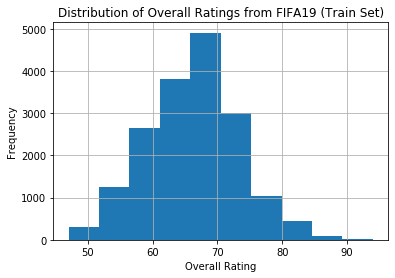

In [10]:
y_train.hist(bins=10)
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Overall Ratings from FIFA19 (Train Set)')
plt.show()

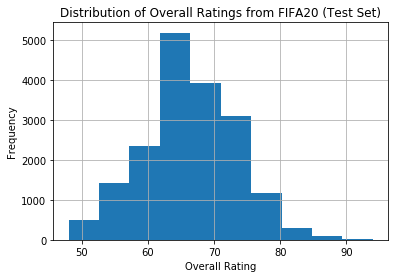

In [11]:
y_test.hist(bins=10)
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Overall Ratings from FIFA20 (Test Set)')
plt.show()

In [12]:
import math

corr_matrix = x_train.corr()
for row_num in range(math.ceil(corr_matrix.shape[0] / 2)):
    for col_num in range(corr_matrix.shape[1]):
        if corr_matrix.iloc[row_num, col_num] > 0.95 and row_num != col_num:
            print(f'Value above found at {corr_matrix.index[row_num]}/{corr_matrix.columns[col_num]}.')

Value above found at goalkeeping_diving/gk_positioning.
Value above found at goalkeeping_diving/goalkeeping_kicking.
Value above found at goalkeeping_diving/gk_handling.
Value above found at goalkeeping_diving/gk_diving.
Value above found at goalkeeping_diving/goalkeeping_positioning.
Value above found at goalkeeping_diving/gk_reflexes.
Value above found at goalkeeping_diving/goalkeeping_handling.
Value above found at goalkeeping_diving/player_positions_gk.
Value above found at goalkeeping_diving/gk_kicking.
Value above found at goalkeeping_diving/goalkeeping_reflexes.
Value above found at dribbling/skill_dribbling.
Value above found at dribbling/passing.
Value above found at dribbling/skill_ball_control.
Value above found at skill_dribbling/dribbling.
Value above found at gk_positioning/goalkeeping_diving.
Value above found at gk_positioning/goalkeeping_kicking.
Value above found at gk_positioning/gk_speed.
Value above found at gk_positioning/gk_handling.
Value above found at gk_posit

There are a number of high correlation values, but looking at the columns, I wouldn't feel comfortable removing them since many of these are likely coincidence more than purposeful (e.g. high diving stat is directly related to high speed stat).

## Scale the data

This will slightly improve the results as the large number of binary predictors will be adjusted to match the statistics of the players.

In [13]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Predicting the FIFA20 overall with FIFA19 data

The purpose here is to train our model on the FIFA19 data, which can then be used to predict FIFA20 overall ratings. This will be done with Decision Tree Regressors that are chosen based upon K-fold cross validation. The one with the lowest MSE will determine which is the model used for testing.

In [15]:
depths = range(24, 47, 2)
scores = []

for depth in depths:
    print(f'Evaluating depth of {depth}...')
    dec_tree = DecisionTreeRegressor(max_depth=depth)
    bagger = BaggingRegressor(dec_tree, n_estimators=100)
    result = cross_validate(bagger, x_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=4)
    score = np.abs(np.mean(result['test_score']))
    scores.append(score)
    print(f'Saved score of {score:.5f}.')

Evaluating depth of 24...
Saved score of 16.30310.
Evaluating depth of 26...
Saved score of 16.33157.
Evaluating depth of 28...
Saved score of 16.18941.
Evaluating depth of 30...
Saved score of 16.14617.
Evaluating depth of 32...
Saved score of 16.21793.
Evaluating depth of 34...
Saved score of 16.27323.
Evaluating depth of 36...
Saved score of 16.20708.
Evaluating depth of 38...
Saved score of 16.19603.
Evaluating depth of 40...
Saved score of 16.24472.
Evaluating depth of 42...
Saved score of 16.19868.
Evaluating depth of 44...
Saved score of 16.14906.
Evaluating depth of 46...


/Users/xylamic/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Saved score of 16.21519.


In [16]:
min_idx = np.argmin(scores)
best_depth = depths[min_idx]
best_score = scores[min_idx]

print(f'The best depth was {best_depth} with a score of {best_score:.5f}.')

The best depth was 30 with a score of 16.14617.


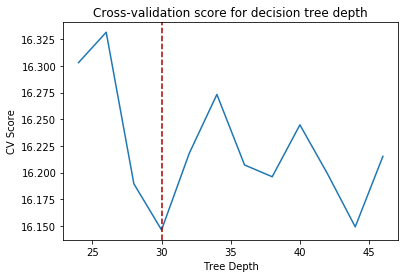

In [17]:
plt.plot(depths, scores)
plt.axvline(x=best_depth, color='#AA0000', linestyle='--')
plt.xlabel('Tree Depth')
plt.ylabel('CV Score')
plt.title('Cross-validation score for decision tree depth')
plt.show()

In [18]:
dec_tree = DecisionTreeRegressor(max_depth=best_depth)
bagger = BaggingRegressor(dec_tree, n_estimators=100)
bagger.fit(x_train_scaled, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=30,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort='deprecated',
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=Tru

In [19]:
accuracy = bagger.score(x_test_scaled, y_test)

print(f'The optimized and scaled tree results in {accuracy:.5f} accurate on the FIFA20 set.')

The optimized and scaled tree results in 0.97838 accurate on the FIFA20 set.


The optimized decision tree regressor resulted in 97.84% accuracy on the FIFA20 data set.

### Try LinearRegression

In [20]:
lr = LinearRegression()
lr.fit(x_train_scaled, y_train)
lr_score = lr.score(x_test_scaled, y_test)

print(f'Checking Linear Regression against test set results in {lr_score:.5f} accurate.')

Checking Linear Regression against test set results in 0.91902 accurate.


A linear regression was performed on the scaled data to do a simple verification that the decision tree regressor was the better choice. This validated this decision as this resulted in 91.90% accuracy. It is also unlikely that regularization would make much more than a small difference as the number are already relatively small.

### Try RandomForest

In [21]:
rfc = RandomForestClassifier(max_depth=90, n_estimators=1000, n_jobs=-1)
rfc.fit(x_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=90, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [22]:
rfc_accuracy = rfc.score(x_test_scaled, y_test)

print(f'The random forest results in {rfc_accuracy:.5f} accurate on the FIFA20 set.')

The random forest results in 0.38169 accurate on the FIFA20 set.


The application of RandomForest gave the worst results, but it's not immediately clear why.

## Determining the most important statistics

Since the coefficients are not easily visible on the decision tree, the linear regression will be used to try to identify the most important statistics.

In [25]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in bagger.estimators_
], axis=0)
feature_importances

array([2.65303413e-05, 4.39308379e-03, 7.64281065e-04, 1.04205561e-07,
       1.49323185e-03, 6.29570854e-03, 1.11499427e-04, 4.78955171e-06,
       2.25053149e-03, 9.41043386e-03, 2.81709155e-03, 1.99076287e-03,
       1.32588277e-05, 1.15920939e-05, 1.36524443e-05, 6.62208915e-03,
       7.84746730e-04, 7.24709539e-04, 1.71024210e-05, 1.81441552e-05,
       2.76894227e-04, 3.01562538e-05, 1.56339898e-05, 2.22570375e-05,
       6.83411092e-03, 1.89904001e-04, 1.64117684e-03, 9.80643392e-06,
       1.34154388e-05, 1.93015018e-07, 1.52534391e-03, 1.13468703e-04,
       8.25688013e-04, 3.68793771e-03, 6.61666966e-05, 2.99865355e-05,
       6.58593301e-05, 1.69944025e-05, 2.67443312e-03, 6.79551442e-03,
       3.90274263e-03, 6.66598738e-03, 2.77125574e-03, 1.65059054e-04,
       7.09955304e-05, 6.76963978e-01, 3.09126352e-03, 1.38499245e-02,
       9.21127577e-04, 7.36543889e-02, 7.00129967e-03, 6.46389869e-05,
       1.30509981e-02, 1.47612157e-03, 1.24869702e-03, 3.50282642e-05,
      

In [26]:
coefs = zip(target_cols, feature_importances)
coefs = sorted(coefs, key=lambda x: np.abs(x[1]), reverse=True)
for c in coefs:
    print(f'{c[0]}:{c[1]}')

movement_reactions:0.6769639779518958
skill_ball_control:0.07365438891124455
defending:0.07323399255204366
mentality_composure:0.013849924497081119
international_reputation:0.01305099811364072
shooting:0.012238526932854845
age:0.010257561322830839
dribbling:0.009410433864596555
goalkeeping_reflexes:0.008413664822103935
goalkeeping_positioning:0.007001299666847611
physic:0.006834110923312768
mentality_positioning:0.006795514418200406
gk_diving:0.006665987379962016
gk_positioning:0.006622089154223268
goalkeeping_diving:0.006295708543250864
gk_reflexes:0.0053148012160400045
attacking_crossing:0.004393083786018331
power_stamina:0.003913845337325638
gk_handling:0.0039027426269229444
passing:0.0036879377089328817
goalkeeping_handling:0.00327027370446543
attacking_short_passing:0.0031806524729657264
defending_standing_tackle:0.0030912635195389044
skill_dribbling:0.0028170915545967013
movement_sprint_speed:0.0027712557419889592
attacking_heading_accuracy:0.0026744331154801653
pace:0.0022505314

Looking at the average feature importance within the decision trees gives some insight into what predictors are the most important. This will be different for goalkeeper & non-goalkeeper as we know they are driven by different sets of stats with few in common.

It was found round the most important predictors, independent of position, were:
Movement_reactions (0.6770)
Skill_ball_control (0.0737)
Defending (0.0732)

Following these three, there was a significant drop off to the next predictor with 0.0138 and all remaining predictors falling within 0.01 of each other.


## Reviewing the highest rated players

Any necessary reviewing of the data around the players with the highest overall rating.

In [27]:
pd.set_option('display.max_columns', None)
p19_df[p19_df['overall'] >= 92][['sofifa_id', 'short_name', 'overall', 'defending', 'rdm', 'cdm', 'gk_diving', 'gk_reflexes', 'gk_positioning']]

,sofifa_id,short_name,overall,defending,rdm,cdm,gk_diving,gk_reflexes,gk_positioning
0,20801,Cristiano Ronaldo,94,35.0,61,61,0.0,0.0,0.0
1,158023,L. Messi,94,32.0,61,61,0.0,0.0,0.0
2,190871,Neymar Jr,92,32.0,60,60,0.0,0.0,0.0


In [28]:
pd.set_option('display.max_columns', None)
p20_df[p20_df['overall'] >= 92][['sofifa_id', 'short_name', 'overall', 'defending', 'rdm', 'cdm', 'gk_diving', 'gk_reflexes', 'gk_positioning']]

,sofifa_id,short_name,overall,defending,rdm,cdm,gk_diving,gk_reflexes,gk_positioning
0,158023,L. Messi,94,39.0,66,66,0.0,0.0,0.0
1,20801,Cristiano Ronaldo,93,35.0,61,61,0.0,0.0,0.0
2,190871,Neymar Jr,92,32.0,61,61,0.0,0.0,0.0


## Comparing against older version of the game

This is using the regressor model to understand a high level if the algorithm for determining overall ratings has changed from previous games.

In [29]:
# check against previous games
for file in ['players_15.csv', 'players_16.csv', 'players_17.csv', 'players_18.csv']:
    pold_df = pd.read_csv('cleaned_data/' + file)
    
    xold_test = pold_df[target_cols]
    yold_test = pold_df['overall']
    
    xold_test_scaled = scaler.transform(xold_test)
    
    old_accuracy = bagger.score(xold_test_scaled, yold_test)

    print(f'The accuracy for {file} is {old_accuracy:.5f}.')

The accuracy for players_15.csv is 0.93642.
The accuracy for players_16.csv is 0.95052.


/Users/xylamic/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The accuracy for players_17.csv is 0.96504.


/Users/xylamic/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The accuracy for players_18.csv is 0.97157.


The testing against older files indicates that the scoring mechanism has been very similar starting with FIFA18. Prior to that, it seems a different scoring mechanism was used, and dramatically different in FIFA15.